In [45]:
# dependencies and global setup
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("./smartmouse.mlpstyle")
np.set_printoptions(suppress=True, precision=3, linewidth=100)

LOG_LVL = 2
   
def debug(*args):
    if LOG_LVL <= 0:
        print(*args)

def info(*args):
    if LOG_LVL <= 1:
        print(*args)
        
def warning(*args):
    if LOG_LVL <= 2:
        print(*args)
        
def log(*args):
    if LOG_LVL < 100:
        print(*args)


# Time Optimal Velocity Profiles

***

When the maze solver commands that the robot go forward, it can say that it must go forward one or more squares depending on what it knows about the maze. When we don't know what is after the square we pass through, we must be going slow enough to handle any scenario. In other words, there is some $V_f$ that we must reach by the end of our motion. We also begin motions at this speed, since between we arrived where we are we required that we reach $V_f$ to get there. Therefore, we start and end at $V_f$, and we want to cover some distance $d$ in the fast possible time. To do so, we accelerate at our fixed $a$ until we reach max speed, or until we need to start slowing down (whichever comes first). This gives us a trapezoid shaped velocity profile.

## Going Straight

In [ ]:
%load_ext tikzmagic

In [ ]:
%%tikz -s 400,400
\draw[->] (0,0) -- (10,0);
\draw[->] (0,0) -- (0,5);

\draw[line width=1] (0,0.5) -- (2.5,3);
\draw[line width=1] (2.5,3) -- (5.5,3);
\draw[line width=1] (5.5,3) -- (8,0.5);
\draw[dashed] (0,0.5) -- (10,0.5);
\draw[dashed] (0,3) -- (10,3);
\draw[dashed] (2.5,0) -- (2.5,5);
\draw[dashed] (5.5,0) -- (5.5,5);
\draw[dashed] (8,0) -- (8,5);

\draw (-0.5, 0.5) node {$V_{f}$};
\draw (-0.5, 3) node {$V_{max}$};
\draw (2.5, -0.5) node {$t_b$};
\draw (5.5, -0.5) node {$t_f-t_b$};
\draw (8, -0.5) node {$t_f$};

The time to accelerate from $V_f$ to $V_{max}$ is $t_b = \frac{V-V_f}{a}$. We can substitute this into newtons first equation of motion as follows.

\begin{align}
d &= Vt_b - \frac{1}{2}a{t_b}^2 \\
  &= V\Big(\frac{V-V_f}{a}\Big) - \frac{1}{2}a\Big(\frac{V-V_f}{a}\Big)^2 \\
  &= \Big(\frac{V^2-VV_f}{a}\Big) - \Big(\frac{a(V-V_f)^2}{2a^2}\Big) \\
  &= \Big(\frac{2V^2-2VV_f}{2a}\Big) - \Big(\frac{V^2-2VV_f+{V_f}^2}{2a}\Big) \\
  &= \frac{2V^2-2VV_f - V^2 + 2VV_f - {V_f}^2}{2a} \\
d &= \frac{V^2-{V_f}^2}{2a} \\
\end{align}

For example, if you're at starting at $V_f=0.2\frac{m}{s}$, and you're ramping up to $V=0.5\frac{m}{s}$, and you're acceleration is fixed at the $a=2\frac{m}{s^2}$, the distance you'll need to do that is $d = \frac{0.5 - 0.2}{2*2} = 0.075m$

## Code that proves it

In [ ]:
def profile(V0, Vf, Vmax, d, A, buffer=3e-4):
    v = V0
    x = 0
    a = A
    vs = [v]
    xs = [x]
    a_s = [a]
    
    dt = 0.001
    while x < d:
        x = x + v*dt + a*dt*dt/2.0
        v = v + a*dt
        ramp_d = (v*v+ - Vf*Vf) / (2.0*A)
        if (d-x) < ramp_d + buffer:
            a = -A
        elif v < Vmax:
            a = A
        else:
            a = 0
        
        if v > Vmax:
            v = Vmax
        elif v < Vf:
            v = Vf
                
        xs.append(x)
        vs.append(v)
        a_s.append(a)
        
    return xs, vs, a_s

def graph(title, idx):
    plt.figure()
    plt.title(title)
    # various max speeds
    Vs = [0.35, 0.5, 0.75, 1]
    Vf = 0.01
    V0 = 0.2
    d = 0.35
    a = 2
    for V in Vs:    
        results  = profile(V0, Vf, V, d, a)
        vs = results[1]
        plt.plot(results[idx], label='V={}'.format(V))
        plt.legend(bbox_to_anchor=(1, 1), loc=2)

graph("position", 0)
graph("velocity", 1)
graph("acceleration", 2)
plt.show()

# Constant Jerk (S-Curve) Motion Profiles

I attempted to acheive the trapezoidal motion profiles shown above in the simulator, but it didn't work very well. We would always end up going too fast and be moving too fast at the end of our position. It's clear to see why this is happening, because there is overshoot in the velocity PIDs--the velocity profiles above have instantaneous changes in slope, so infinite change in acceleration, or infinite jerk. Of course, or motors cannot change their torque instantly, so we now consider using constant jerk to give S-curve profiles.

## The overall goal

We ultimately need to be able to set the wheel velocities at each instance to acheive the fastest path to reach a certain distance with a certain final velocity, all while subject to a maximum velocity, acceleration, and jerk. Generally speaking, the fastest path is to apply maximum jerk to reach maximum accelerate as fast as possible, and continue at maximum acceleration until maximum velocity is reached. Then, maintain that maximum velocity until the last possible second, at which point you apply maximum negatve jerk, reach maximum negative acceleration, then final velocity.

We must also consider the case where there is not enough distance to reach our maximum velocity. In this case, we can instead calculate the maximum velocity we can reach given this time-optimal profile and the available distance. To do this, we can take the derivative of the equation for total time with respect to the maximum speed, then find the maximum speed for which this derivative is zero. We then plan to ramp up to this max speed, then back down to our desired final velocity.

In the case where we have plenty of distance, we will ramp up to max velocity, maintain that maximum velocity for a certain distance, then ramp back down to our final velocity. We will call these **phase 1**, **phase 2**, and  **phase 3**. As mentioned earlier, sometimes we will skip phase 2 entirely. Another weird assumption I'm going to make is that we always have enough time to reach maximum acceleration. If this isn't true than a few of our equations break, but in smartmouse this will never happen.

![velocity profile](./velocity_profile.png)

**Definition of variables**

$v_o$ is the initial velocity

$v_s$ is the maximum velocity

$v_f$ is the final velocity

$a_s$ is the maximum acceleration

$T$ is the time to reach max velocity

$t_1$ is the time to transition from 0 to max acceleration

$t_2$ is the time to when we begin to transition from max acceleration back to 0

t_1 = 0.2 t_2 = 1.0
t_m1 = 1.2 t_m2 = 1.2
t_3 = 1.4 t_4 = 2.6999999999999997
t_f = 2.9
v_0 = 1
v_1 = 1.2 v_2 = 2.8
v_m = 3
v_3 = 2.8 v_4 = 0.2
v_f = 0
d = inf


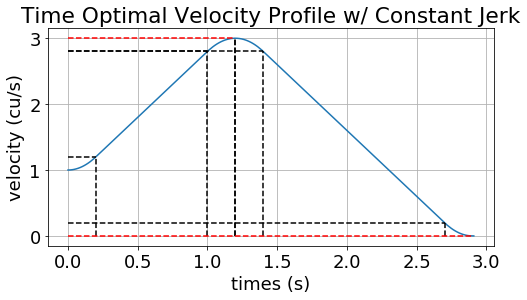

In [71]:
def profile_distance(v_0, v_f, a_m, j_m, v_m):
    return (a_m**2*(v_0+v_f+2*v_m)-j_m*(v_0**2+v_f**2-2*v_m**2))/(2*a_m*j_m)

def simulate_profile(v_0, v_f, a_m, j_m, v_m, V=np.inf, d=np.inf):
    v_m_ = min(v_m, V)
    
    # ramp up
    t_1 = a_m / j_m
    v_1 = v_0 + a_m**2 / (2 * j_m)
    v_2 = v_m_ - a_m**2 / (2 * j_m)
    t_2 = t_1 + (v_2 - v_1) / a_m
    t_m1 = t_2 + t_1

    # middle section
    if v_m > V and not np.isinf(d):
        t_m2 = t_m1 + (d - profile_distance(v_0, v_f, a_m, j_m, V))/V
    else:
        t_m2 = t_m1

    # ramp down
    t_3 = t_m2 + a_m / j_m
    v_3 = v_m_ - a_m**2 / (2 * j_m)  # also equal to v_2
    v_4 = v_f + a_m**2 / (2 * j_m)
    t_4 = t_3 - (v_4 - v_3) / a_m
    t_f = t_4 + t_1
    
    print('t_1 =', t_1, 't_2 =', t_2)
    print('t_m1 =', t_m1, 't_m2 =', t_m2)
    print('t_3 =', t_3, 't_4 =', t_4)
    print('t_f =', t_f)
    print('v_0 =', v_0,)
    print('v_1 =', v_1, 'v_2 =', v_2)
    print('v_m =', v_m_)
    print('v_3 =', v_3, 'v_4 =', v_4)
    print('v_f =', v_f)
    print('d =', d)

    vs = []
    T = t_f+0.01
    N = 200
    ts = np.linspace(0, T, N)
    for t in ts:
        if t <= t_1: # achieve max acceleration
            v_t = v_0 + j_m * t**2 / 2.0
        elif t <= t_2: # maintain max acceleration
            v_t = v_1 + a_m * (t - t_1)
        elif t <= t_m1: # acheive max velocity
            v_t = v_2 + a_m * (t - t_2) - j_m * (t - t_2)**2 / 2.0
        elif t <= t_m2: # maintain max velocity
            v_t = v_m_
        elif t <= t_3: # acheive max deceleration
            v_t = v_m_ - j_m * (t - t_m2)**2 / 2.0
        elif t <= t_4: # maintain max deceleration
            v_t = v_3 - a_m * (t - t_3)
        elif t < t_f: # acheive final velocity
            v_t = v_4 - a_m * (t - t_4) + j_m * (t - t_4)**2 / 2.0
        else:
            v_t = v_f
        vs.append(v_t)

    plt.figure(figsize=(8,4))
    plt.plot(ts, vs, label='velocity')
    plt.plot([t_1, t_1], [0, v_1], color='k', linestyle='--')
    plt.plot([t_2, t_2], [0, v_2], color='k', linestyle='--')
    plt.plot([t_m1, t_m1], [0, v_m_], color='k', linestyle='--')
    plt.plot([t_m2, t_m2], [0, v_m_], color='k', linestyle='--')
    plt.plot([t_3, t_3], [0, v_3], color='k', linestyle='--')
    plt.plot([t_4, t_4], [0, v_4], color='k', linestyle='--')
    plt.plot([0, t_1], [v_1, v_1], color='k', linestyle='--')
    plt.plot([0, t_2], [v_2, v_2], color='k', linestyle='--')
    plt.plot([0, t_m1], [v_m_, v_m_], color='r', linestyle='--')
    plt.plot([0, t_3], [v_3, v_3], color='k', linestyle='--')
    plt.plot([0, t_4], [v_4, v_4], color='k', linestyle='--')
    plt.plot([0, t_f], [v_f, v_f], color='r', linestyle='--')
    plt.xlabel("times (s)")
    plt.ylabel("velocity (cu/s)")
    plt.title("Time Optimal Velocity Profile w/ Constant Jerk")
    plt.grid()
    plt.show()
    
simulate_profile(v_0=1, v_f=0, a_m=2, j_m = 10, v_m=3)

## Calculating max velocity

For the profile defined above, we are picking $v_m$, and the distance the robot will travel over the whole profile is a function of this. If $v_m$ were lower the robot would travel a shorter distance, and if it were higher the robot would travel further. We can instead solve for the $v_m$ that makes the robot travel a certain distance. With that, we can solve for a velocity profile that will take us to the next of the next unexplored cell, with some final speed, from any initial speed, as fast as possible, while obeying max jerk and acceleration.

In [72]:
def compute_v_max(v_0, v_f, a_m, j_m, d):
    """
    v_0 - initial velocity (cu/s)
    v_f - final velocity (cu/s)
    a_m - max acceleration (cu/s^2)
    j_m - max jerk (cu/s^3)
    d   - distance to travel
    """
    a = 1/a_m
    b = a_m/j_m
    c = (a_m**2*(v_0+v_f) - j_m*(v_0**2+v_f**2))/(2*a_m*j_m) - d
    v_max = (-b + np.sqrt(b**2-4*a*c))/(2*a)
    return v_max

v_m = 6.263222952014589
d= 6.733333333333333
t_1 = 0.3333333333333333 t_2 = 1.2526445904029178
t_m1 = 1.585977923736251 t_m2 = 1.585977923736251
t_3 = 1.9193112570695843 t_4 = 2.638622514139169
t_f = 2.9719558474725023
v_0 = 0
v_1 = 0.8333333333333334 v_2 = 5.429889618681256
v_m = 6.263222952014589
v_3 = 5.429889618681256 v_4 = 1.8333333333333335
v_f = 1
d = inf


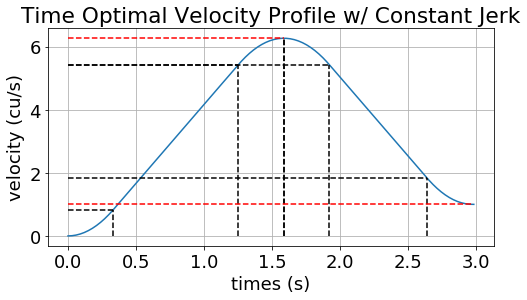

In [73]:
def too_fast():
    v_0=0
    v_f=1
    a_m=5
    j_m=15
    
    v_m = compute_v_max(v_0, v_f, a_m, j_m, d=10)
    
    print("v_m =", v_m)
    print("d=", profile_distance(v_0, v_f, a_m, j_m, v_m=5))

    simulate_profile(v_0, v_f, a_m, j_m, v_m)
    
too_fast()


So far in solving for $v_m$, we are have ignored the hardware limit. Let's call that $\mathbb{V}$. If we have a really far distance, it's possible that $v_m > \mathbb{V}$, and in that case we must clamp $v_m=\mathbb{V}$, and create a intermediate section of the profile where we maintain $\mathbb{V}$. An example is shown below

t_1 = 0.3333333333333333 t_2 = 0.7999999999999999
t_m1 = 1.1333333333333333 t_m2 = 2.3583333333333334
t_3 = 2.691666666666667 t_4 = 2.9583333333333335
t_f = 3.291666666666667
v_0 = 0
v_1 = 0.8333333333333334 v_2 = 3.1666666666666665
v_m = 4
v_3 = 3.1666666666666665 v_4 = 1.8333333333333335
v_f = 1
d = 9.5


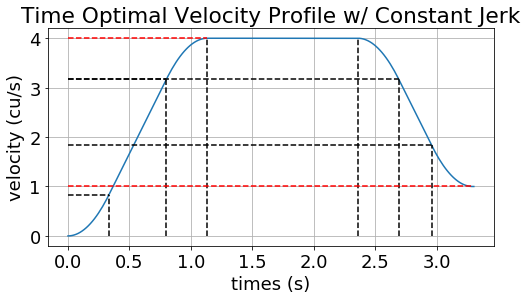

In [74]:
def just_right():
    v_0=0
    v_f=1
    a_m=5
    j_m=15
    V = 4
    d = 9.5
    
    v_m = compute_v_max(v_0, v_f, a_m, j_m, d)
    simulate_profile(v_0, v_f, a_m, j_m, v_m, V, d)
    
just_right()

## Example from the simulator

Here's an example what it looks like in simulation
![s-curve](pid_screenshot_14:57:04_11_03_2018.png)

t_1 = 0.1 t_2 = 0.08503845926290016
t_m1 = 0.18503845926290016 t_m2 = 0.18503845926290016
t_3 = 0.28503845926290017 t_4 = 0.4600769185258003
t_f = 0.5600769185258003
v_0 = 0.95
v_1 = 1.2 v_2 = 1.1251922963145007
v_m = 1.3751922963145007
v_3 = 1.1251922963145007 v_4 = 0.25
v_f = 0
d = 0.473


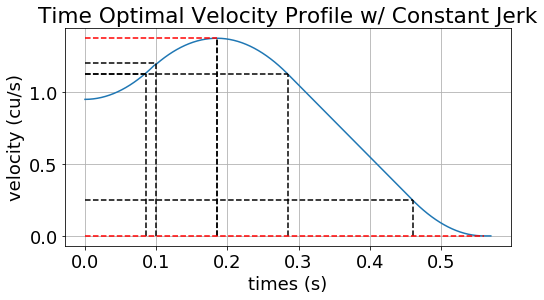

In [75]:
def first_half_cell():
    v_0 = 0.95
    v_f = 0
    a_m = 5
    j_m = 50
    V   = 4
    d   = 0.473
    
    v_m = compute_v_max(v_0, v_f, a_m, j_m, d)
    simulate_profile(v_0, v_f, a_m, j_m, v_m, V, d)
    
first_half_cell()

# General Form Trajectory Planning

Let's start out with a generating trajectories that are not time optimal, but rely on specifying the final time $v_f$. For smartmouse, our state space is $[x, y, \theta]$, and a turn can be defined as starting at a point $[x_0, y_0, \theta_0]$ and going to $[x_f, y_f, \theta_0]$. Of course, we also want to specify the velocities at these point, $[\dot{x}_0, \dot{y}_0,\dot{\theta}_0]$ and $[\dot{x}_f, \dot{y}_f,\dot{\theta}_f]$. We have four constraints, so if we want to fit a smooth polynomial to those points we need a 4th order polynomial.

$$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3$$
$$\dot{q}(t) = a_1 + 2a_2t + 3a_3t^2$$

If we sub in our constraints, we get the following system of equations.

\begin{align}
q(0) &= a_0 \\
\dot{q}(0) &= a_1 \\
q(t_f) &= a_0 + a_1t_f + a_2{t_f}^2 + a_3{t_f}^3\\
\dot{q}(t_f) &= a_1 + 2a_2t_f + 3a_3{t_f}^2\\
\end{align}

In matrix form that looks like:
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
1 & t_f & t_f^2 & t_f^3 \\
0 & 1 & 2t_f & 3t_f^2 \\
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\end{bmatrix} =
\begin{bmatrix}
q(0) \\
\dot{q}(0) \\
q(t_f) \\
\dot{q}(t_f) \\
\end{bmatrix}
\end{equation}

It can be shown that the matrix on the left is invertable, so long as $t_f-t_0 > 0$. So we can invert and solve this equation and get all the $a$ coefficients. We can then use this polynomial to generate the $q(t)$ and $\dot{q}(t)$ -- our trajectory.

In [ ]:
def simple_traj_solve(q_0, q_f, q_dot_0, q_dot_t_f, t_f):
    # Example: you are a point in space (one dimension) go from rest at the origin to at rest at (0.18, 0, 0) in 1 second
    q_0 = np.array([0])
    q_dot_0 = np.array([0])
    q_t_f = np.array([0.18])
    q_dot_t_f = np.array([0])

    b = np.array([q_0, q_dot_0, q_t_f, q_dot_t_f])
    a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
    log(a, b)
    coeff = np.linalg.solve(a, b)
    log(coeff)
    
    return coeff

simple_traj_info = (0, 0, 0.18, 0, 1)
simple_traj_coeff = simple_traj_solve(*simple_traj_info)

Here you can see that the resulting coeffictions are $a_0=0$, $a_1=0$, $a_2=0.54$, $a_0=-0.36$. Intuitively, this says that we're going to have positive acceleration, but our acceleration is going to slow down over time. Let's graph it!

In [ ]:
def simple_traj_plot(coeff, t_f):
    dt = 0.01
    ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
    qs = ts@coeff
    plt.plot(ts[:,1], qs, label="x")
    plt.xlabel("time (seconds)")
    plt.xlabel("X (meters)")
    plt.legend(bbox_to_anchor=(1,1), loc=2)
    plt.show()

simple_traj_plot(simple_traj_coeff, simple_traj_info[-1])

**ooooooooooh so pretty**

Let's try another example, now with our full state space of $[x, y, \theta]$.

In [ ]:
def no_dynamics():
    # In this example, we go from (0.18, 0.09, 0) to (0.27,0.18, -1.5707). Our starting and ending velocities are zero
    q_0 = np.array([0.09,0.09,0])
    q_dot_0 = np.array([0,0,0])
    q_f = np.array([0.27,0.18,-1.5707])
    q_dot_f = np.array([0,0,0])
    t_f = 1

    b = np.array([q_0, q_dot_0, q_f, q_dot_f])
    a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
    coeff = np.linalg.solve(a, b)
    log(coeff)

    dt = 0.1
    ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
    qs = ts@coeff

    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.gca().set_adjustable("box")
    plt.subplot(221)
    plt.plot(ts[:,1], qs[:,0])
    plt.xlabel("time (seconds)")
    plt.title("x")
    plt.subplot(222)
    plt.plot(ts[:,1], qs[:,1])
    plt.xlabel("time (seconds)")
    plt.title("y")
    plt.subplot(223)
    plt.plot(ts[:,1], qs[:,2])
    plt.xlabel("time (seconds)")
    plt.title(r"$\theta$")
    plt.subplot(224)
    plt.scatter(qs[:,0], qs[:,1])
    plt.axis('equal')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()
    
no_dynamics()

Well, they are smooth, but these are not possible to execute! The robot cannot simply translate sideways.

# Trajectory Planning With a Simple Dynamics Model

***

In [ ]:
%%tikz -s 100,100

\draw [rotate around={-45:(0,0)}] (-.5,-1) rectangle (0.5,1);
\filldraw (0,0) circle (0.125);

\draw [->] (0,0) -- (0,1.5);
\draw [->] (0,0) -- (1.5,0);
\draw [->] (0,0) -- (1.5,1.5);
\draw (1.2, -0.2) node {$x$};
\draw (-0.2, 1.2) node {$y$};
\draw (1, 1.2) node {$v$};


We need to change our constraints to the system of equations. Specifically, we need our dynamics model. For now, let's assume a simplified car model.

$$ \dot{x} = v\cos(\theta) $$
$$ \dot{y} = v\sin(\theta) $$

This basically claims that for any instant in time the robot is moving a constant velocity along $\theta$. This isn't very accurate, but let's just start with that since the real dynamics of our robot are more complex.

First we will bring in the constraints from before. We must satisfy specific initial and final positions in $[x, y, \theta]$. I've used new letters for cofficients to avoid confusion.

\begin{align}
x_0 &= c_0 + c_1(0) + c_2(0)^2 + c_3(0)^3 + c_3(0)^4 + c_3(0)^5 \\
y_0 &= d_0 + d_1(0) + d_2(0)^2 + d_3(0)^3 + d_3(0)^4 + d_3(0)^5 \\
x_{t_f} &= c_0 + c_1(t_f) + c_2(t_f)^2 + c_3(t_f)^3 + c_3(t_f)^4 + c_3(t_f)^5 \\
y_{t_f} &= d_0 + d_1(t_f) + d_2(t_f)^2 + d_3(t_f)^3 + d_3(t_f)^4 + d_3(t_f)^5 \\
\end{align}

Notice here we have 12 unknowns, $c_0 \dots c_5$ and $d_0 \dots d_5$. So we're gonna need more equations for there to be a unique solution. Also notice we haven't defined any constraints related to our dynamics model. That would be a good place to get our other equations!

First, we want to be able to specify initial velocity $v_0$ and final velocity $v_{t_f}$. It is easlier to just constrain $\dot{x}_0$,  $\dot{y}_0$,  $\dot{x}_{t_f}$,  $\dot{y}_{t_f}$. So if we want to specify that we start facing $\tfrac{\pi}{2}$ going 1m/s, we'd just specify $cos(\tfrac{\pi}{2})$ for $\dot{x}_0$ and $sin(\tfrac{\pi}{2})$ for $\dot{y}_0$.

\begin{align}
\dot{x}_0 &= c_1 \\
\dot{y}_0 &= d_1 \\
\dot{x}_{t_f} &= (0)c_0 + (1)c_1 + 2t_fc_2 + 3{t_f}^2c_3 + 4{t_f}^3c_4 + 5{t_f}^4c_5 \\
\dot{y}_{t_f} &= (0)d_0 + (1)d_1 + 2t_fd_2 + 3{t_f}^2d_3 + 4{t_f}^3d_4 + 5{t_f}^4d_5
\end{align}

Let's also make sure x and y components obey trigonometry.

\begin{align}
  v\cos(\theta)\sin(\theta) + v\cos(\theta)\sin(\theta) &= v\sin(2\theta) \\
  \dot{x}\sin(\theta) + \dot{y}\sin(\theta) &= v\sin(2\theta)
\end{align}

We can get two equations out of this by specifying initial and final velocities

\begin{align}
v_0\sin(2\theta_0) &= \dot{x}_0\sin(\theta_0) + \dot{y}_0\cos(\theta_0) \\
v_{t_f}\sin(2\theta_{t_f}) &= \dot{x}_{t_f}\sin(\theta_{t_f}) + \dot{y}_{t_f}\cos(\theta_{t_f})
\end{align}

We should write out the full form though, to make things in terms of our coefficients.

\begin{align}
v(0)\sin(2\theta_0) &= \Big[c_1 + 2(0)c_2 + 3(0)^2c_3 + 4(0)^3c_4 + 5(0)^4c_5\Big]\sin(\theta_0) + \Big[d_1 + 2(0)d_2 + 3(0)^2d_3 + 4(0)^3d_4 + 5(0)^4d_5\Big]\cos(\theta_0) \\
v(0)\sin(2\theta_0) &= \sin(\theta_0)c_1 + \cos(\theta_0)d_1
\end{align}

\begin{align}
v(t_f)\sin(2\theta_{t_f}) &= \Big[c_1 + 2(t_f)c_2 + 3(t_f)^2c_3 + 4(t_f)^3c_4\ + 5(t_f)^4c_5\Big]\sin(\theta_{t_f}) + \Big[d_1 + 2(t_f)d_2 + 3(t_f)^2d_3 + 4(t_f)^3d_4 + 5(t_f)^4d_5\Big]\cos(\theta_{t_f}) \\
v(t_f)\sin(2\theta_{t_f}) &= \sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 + 4\sin(\theta_{t_f}){t_f}^3c_4  + 5\sin(\theta_{t_f}){t_f}^4c_5 + \cos(\theta_{t_f})d_1 + 2\cos(\theta_{t_f})t_fd_2 + 3\cos(\theta_{t_f}){t_f}^2d_3 + 4\cos(\theta_{t_f}){t_f}^3d_4 + 5\cos(\theta_{t_f}){t_f}^4d_5 \\
\end{align}

The last two equations constrains the robot from moving in any direction other than its heading. Of course it must relate $\dot{x}$ to $\dot{y}$. Still not totally sure how we got this equation so I'm just copying it from some slides$\dots$. However you can plug in some example values and check. For instance translating sideways violates this equation: set $\dot{x}=1$, $\dot{y}=0$, $v=1$, $\theta=\tfrac{\pi}{2}$.

\begin{align}
v\cos(\theta)\sin(\theta) - v\cos(\theta)\sin(\theta) &= 0 \\
v\cos(\theta)\sin(\theta) - v\sin(\theta)\cos(\theta) &= 0 \\
\dot{x}\sin(\theta) - \dot{y}\cos(\theta) &= 0
\end{align}

and again written out fully in terms of our coefficients

\begin{align}
\Big[c_1 + 2(0)c_2 + 3(0)^2c_3 + 4(0)^3c_4 + 5(0)^4c_5\Big]\sin(\theta_0) - \Big[d_1 + 2(0)d_2 + 3(0)^2d_3 + 4(0)^3d_4 + 5(0)^4d_5\Big]\cos(\theta_0) &= 0 \\
\sin(\theta_0)c_1 - \cos(\theta_0)d_1 &= 0
\end{align}

\begin{align}
\Big[c_1 + 2(t_f)c_2 + 3(t_f)^2c_3 + 4(t_f)^3c_4 + 5(t_f)^4c_5\Big]\sin(\theta_{t_f}) - \Big[d_1 + 2(t_f)d_2 + 3(t_f)^2d_3 + 4(t_f)^3d_4 + 5(t_f)^4d_5\Big]\cos(\theta_{t_f}) &= 0 \\
\sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 + 4\sin(\theta_{t_f}){t_f}^3c_4  + 5\sin(\theta_{t_f}){t_f}^4c_5 - \cos(\theta_{t_f})d_1 - 2\cos(\theta_{t_f})t_fd_2 - 3\cos(\theta_{t_f}){t_f}^2d_3 - 4\cos(\theta_{t_f}){t_f}^3d_4 - 5\cos(\theta_{t_f}){t_f}^4d_5 &= 0
\end{align}

Ok, that should work. Now let's write it out in matrix form. We use $c$ and $s$ to shorten $\sin$ and $\cos$.

\setcounter{MaxMatrixCols}{20}
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & s(\theta_0) & 0 & 0 & 0 & 0 & 0 & c(\theta_0) & 0 & 0 & 0 & 0\\
0 & s(\theta_0) & 0 & 0 & 0 & 0 & 0 & -c(\theta_0) & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\
1 & t & {t_f}^2 & {t_f}^3 & {t_f}^4 & {t_f}^5 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & t_f & {t_f}^2 & {t_f}^3 & {t_f}^4 & {t_f}^5 \\
0 & s(\theta_{t_f}) & 2s(\theta_{t_f})t_f & 3s(\theta_{t_f}){t_f}^2 & 4s(\theta_{t_f}){t_f}^3 & 5s(\theta_{t_f}){t_f}^4 & 0 & c(\theta_{t_f}) & 2c(\theta_{t_f}){t_f} & 3c(\theta_{t_f}){t_f}^2 & 4c(\theta_{t_f}){t_f}^3 & 5c(\theta_{t_f}){t_f}^4 \\
0 & s(\theta_{t_f}) & 2s(\theta_{t_f})t_f & 3s(\theta_{t_f}){t_f}^2 & 4s(\theta_{t_f}){t_f}^3 & 5s(\theta_{t_f}){t_f}^4 & 0 & -c(\theta_{t_f}) & -2c(\theta_{t_f}){t_f} & -3c(\theta_{t_f}){t_f}^2 & -4c(\theta_{t_f}){t_f}^3 & -5c(\theta_{t_f}){t_f}^4 \\
0 & 1 & 2t_f & 3{t_f}^2 & 4{t_f}^3 & 5{t_f}^4 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 2t_f & 3{t_f}^2 & 4{t_f}^3 & 5{t_f}^4
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
c_4 \\
c_5 \\
d_0 \\
d_1 \\
d_2 \\
d_3 \\
d_4 \\
d_5
\end{bmatrix} =
\begin{bmatrix}
x_0 \\
y_0 \\
0 \\
v_0s(2\theta_0) \\
c(\theta_0)v_0 \\
s(\theta_0)v_0 \\
x_{t_f} \\
y_{t_f} \\
0 \\
v_{t_f}s(2\theta_{t_f}) \\
c(\theta_{t_f})v_{t_f} \\
s(\theta_{t_f})v_{t_f} \\
\end{bmatrix}
\end{equation}

In [ ]:
# Let's solve this in code like we did before
def plot_vars(traj_plan):
    dt = 0.001
    T = np.arange(0, traj_plan.get_t_f()+dt, dt)
    xts = np.array([[1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] for t in T])
    xdts = np.array([[0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4), 0, 0, 0, 0, 0, 0] for t in T])
    yts = np.array([[0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] for t in T])
    ydts = np.array([[0, 0, 0, 0, 0, 0, 0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4)] for t in T])
    xs = xts@traj_plan.get_coeff()
    ys = yts@traj_plan.get_coeff()
    xds = xdts@traj_plan.get_coeff()
    yds = ydts@traj_plan.get_coeff()
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('axes.formatter', useoffset=False)
    plt.figure(figsize=(10, 2.5))
    
    plt.subplot(141)
    plt.plot(T, xs, linewidth=3)
    plt.xlabel("time (seconds)")
    plt.title("X")

    plt.subplot(142)
    plt.plot(T, ys, linewidth=3, color='r')
    plt.xlabel("time (seconds)")
    plt.title("Y")

    plt.subplot(143)
    plt.plot(T, xds, linewidth=3, color='g')
    plt.xlabel("time (seconds)")
    plt.title("$\dot{x}$")
    plt.tight_layout()
    
    plt.subplot(144)
    plt.plot(T,yds, linewidth=3, color='y')
    plt.xlabel("time (seconds)")
    plt.title("$\dot{y}$")
    plt.tight_layout()
    plt.show()
    
def plot_traj(traj_plan):
    dt = 0.03
    T = np.arange(0, traj_plan.get_t_f()+dt, dt)
    xts = np.array([[1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] for t in T])
    yts = np.array([[0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] for t in T])
    xs = xts@traj_plan.get_coeff()
    ys = yts@traj_plan.get_coeff()
    plot_traj_pts(xs, ys, T, traj_plan.waypoints)
    
def plot_traj_pts(xs, ys, T, waypoints):
    plt.figure(figsize=(5, 5))
    plt.title("Trajectory")
    plt.xlabel("X")
    plt.ylabel("Y")
    W = 2
    plt.xlim(0, W * 0.18)
    plt.ylim(0, W * 0.18)
    plt.xticks(np.arange(2*W+1)*0.09)
    plt.yticks(np.arange(2*W+1)*0.09)
    plt.grid(True)    
    plt.gca().set_axisbelow(True)
    
    for t, pt in waypoints:
        arrow_dx = cos(pt.theta) * (pt.v) * 0.1
        arrow_dy = sin(pt.theta) * (pt.v) * 0.1
        plt.arrow(pt.x, pt.y, arrow_dx, arrow_dy, head_width=0.005, head_length=0.005, width=0.001, fc='k', ec='k')    
    
    plt.scatter(xs, ys, marker='.', linewidth=0)

    plt.show()

In [ ]:
from math import sin, cos, pi
from collections import namedtuple

WayPoint = namedtuple('WayPoint', ['x', 'y', 'theta', 'v'])

class TrajPlan:
    def x_constraint(t):
        return [1, t, pow(t, 2), pow(t, 3), pow(t, 4), pow(t, 5), 0, 0, 0, 0, 0, 0]

    def y_constraint(t):
        return [0, 0, 0, 0, 0, 0, 1, t, pow(t, 2), pow(t, 3), pow(t, 4), pow(t, 5)]

    def non_holonomic_constraint(theta_t, t):
        s_t = sin(theta_t)
        c_t = cos(theta_t)
        t_2 = pow(t, 2)
        t_3 = pow(t, 3)
        t_4 = pow(t, 4)
        return [0, s_t, 2 * s_t * t, 3 * s_t * t_2, 4 * s_t * t_3, 5 * s_t * t_4, 0, c_t, 2 * c_t * t, 3 * c_t * t_2, 4 * c_t * t_3, 5 * c_t * t_4]

    def trig_constraint(theta_t, t):
        s_t = sin(theta_t)
        c_t = cos(theta_t)
        t_2 = pow(t, 2)
        t_3 = pow(t, 3)
        t_4 = pow(t, 4)
        return [0, s_t, 2 * s_t * t, 3 * s_t * t_2, 4 * s_t * t_3, 5 * s_t * t_4, 0, -c_t, -2 * c_t * t, -3 * c_t * t_2, -4 * c_t * t_3, -5 * c_t * t_4]

    def x_dot_constraint(t):
        return [0, 1, 2 * t, 3 * pow(t, 2), 4 * pow(t, 3), 5 * pow(t, 4), 0, 0, 0, 0, 0, 0]

    def y_dot_constraint(t):
        return [0, 0, 0, 0, 0, 0, 0, 1, 2 * t, 3 * pow(t, 2), 4 * pow(t, 3), 5 * pow(t, 4)]
        
    def solve(self, waypoints):
        # Setup the matrices to match the equation above
        A = []
        b = []
        
        for t, pt in waypoints:
            A += [TrajPlan.x_constraint(t),
                      TrajPlan.y_constraint(t), 
                      TrajPlan.non_holonomic_constraint(pt.theta, t), 
                      TrajPlan.trig_constraint(pt.theta, t),
                      TrajPlan.x_dot_constraint(t),
                      TrajPlan.y_dot_constraint(t)]
            b += [pt.x,
                      pt.y,
                      0,
                      pt.v*sin(2*pt.theta),
                      cos(pt.theta)*pt.v,
                      sin(pt.theta)*pt.v]

        A = np.array(A)
        b = np.array(b)
        rank = np.linalg.matrix_rank(A)

        if rank == A.shape[1]:
            if A.shape[0] == A.shape[1]:
                coeff = np.linalg.solve(A, b)
            else:
                warning("not square, using least squares.".format(A.shape))
                coeff, resid, rank, s = np.linalg.lstsq(A, b)
        else:
            warning("Ranks don't match! {} equations {} variables, using least squares".format(rank, A.shape[1]))
            coeff, resid, rank, s = np.linalg.lstsq(A, b)

        debug("rank {}".format(rank))
        debug("A: \n{}".format(A))
        debug("coeff: \n{}".format(coeff))
        error = np.sum(np.power(A@coeff - b, 2))
        if error > 1e-10:
            info("These two vectors should be equal! But there is error.")
            info("b is: \n{}".format(b))
            info("A@coeff is: \n{}".format(A@coeff))
        info("RMS Error of solution to equations")
        info(error)
        
        self.coeff = coeff
        self.waypoints = waypoints
        
    def get_coeff(self):
        return self.coeff
    
    def get_t_f(self):
        return self.waypoints[-1][0]

## Example Plots

In [ ]:
# forward 1 cell, start from rest, end at 40cm/s, do it in .5 seconds
LOG_LVL = 5
fwd_1 = TrajPlan()
fwd_1.solve([(0, WayPoint(0.09, 0.09, pi/2, 0)), (0.5, WayPoint(0.09, 0.27, pi/2, 0.6))])
plot_vars(fwd_1)
plot_traj(fwd_1)

In [ ]:
# continue by turning right 90 degrees
LOG_LVL = 1
turn_right = TrajPlan()
turn_right.solve([(0, WayPoint(0.09, 0.18, pi/2, 0.4)), (0.5, WayPoint(0.18, 0.27, 0, 0.4))])
plot_vars(turn_right)
plot_traj(turn_right)

In [ ]:
# 3 waypoints!
LOG_LVL = 1
turn_right = TrajPlan()
turn_right.solve([(0, WayPoint(0.09, 0.09, pi/2, 0.0)), (0.5, WayPoint(0.18, 0.18, 0, 0.35)), (1, WayPoint(0.27, 0.27, pi/2, 0))])
plot_vars(turn_right)
plot_traj(turn_right)

**Note for this system of equations with 3 waypoints, there is no solution. However, the error of the solution found is very small.**

Now let's find one that really sucks!

In [ ]:
# 4 waypoints!
LOG_LVL = 1
turn_right = TrajPlan()
turn_right.solve([(0, WayPoint(0.09, 0.0, pi/2, 0.1)),
                  (1, WayPoint(0.09, 0.18, pi/2, 0.1)),
                  (2, WayPoint(0.18, 0.27, 0, 0.1)),
                  (3, WayPoint(0.27, 0.27, 0, 0.1))])
plot_traj(turn_right)

# Trajectory Following

***

Now that we have a trajectory, we want to design a controller that will follow it as closely as possible. To do this, I'm just going to do a proportional controller. Later we will design an optimal controller. We want to make sure the robot is on the path, facing along the path, and going the right speed. When all of these are true the change in speed should be zero. Let's come up with an equation to relate current pose and velocity to the desired pose and velocity. Let our outputs be the linear velocity $v$ and the rotational velocity $w$.

$$ w = \bar{w} + d*P_1 + (\bar{\theta} - \theta)P_2$$
$$ v = \bar{v} + l*P_3$$

where $v_d$ is desired velocity, $\theta_d$ is the desired angle, $d$ is signed distance to the planned trajectory (to the right of the plan is positive), $v_d$ and $w_d$ are the desired velocities of the robot, and $P_1$, $P_2$, and $P_3$ are constants. Essentially what we're saying with the first equation is that when you're far off the trajectory you need to turn harder to get back on to it, but you also need to be aligned with it. The second equation says if you're lagging behind your plan speed up, or slow down if you're overshooting.

In [ ]:
from math import atan2, sqrt

LOG_LVL = 5
def simulate(q_0, waypoints, P_1, P_2, P_3, A=3):
    traj = TrajPlan()
    traj.solve(waypoints)
    
    dt = 0.01
    x = q_0[0]
    y = q_0[1]
    theta = q_0[2]
    v = q_0[3]
    w = q_0[4]
    actual_v = q_0[3]
    actual_w = q_0[4]
    v_acc = A * dt
    TRACK_WIDTH_M = 0.0633
    w_acc = v_acc / (TRACK_WIDTH_M/2)
    T = np.arange(0, traj.get_t_f()+dt, dt)
    x_bar_list = []
    y_bar_list = []
    x_list = []
    y_list = []
    for t in T:
        x_bar = [1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] @ traj.get_coeff()
        dx_bar = [0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4), 0, 0, 0, 0, 0, 0] @ traj.get_coeff()
        ddx_bar = [0, 0, 0, 0, 0, 0, 0, 0, 2, 6*t, 12*pow(t,2), 20*pow(t,3)] @ traj.get_coeff()
        y_bar = [0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] @ traj.get_coeff()
        dy_bar = [0, 0, 0, 0, 0, 0, 0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4)] @ traj.get_coeff()
        ddy_bar = [0, 0, 0, 0, 0, 0, 0, 0, 2, 6*t, 12*pow(t,2), 20*pow(t,3)] @ traj.get_coeff()
        theta_bar = atan2(dy_bar, dx_bar)
        v_bar = sqrt(dx_bar*dx_bar + dy_bar*dy_bar)
        w_bar = 1/v_bar * (ddy_bar*cos(theta_bar) - ddx_bar*sin(theta_bar));
    
        # simple Dubin's Car forward kinematics
        x += cos(theta) * actual_v * dt
        y += sin(theta) * actual_v * dt
        theta += actual_w * dt
        
        # control
        euclidian_error = np.sqrt(pow(x_bar - x, 2) + pow(y_bar - y, 2))
        transformed_x = (x - x_bar) * cos(-theta_bar) + (y - y_bar) * -sin(-theta_bar)
        transformed_y = (x - x_bar) * sin(-theta_bar) + (y - y_bar) * cos(-theta_bar)
        right_of_traj = transformed_y < 0
        signed_euclidian_error = euclidian_error if right_of_traj else -euclidian_error
        lag_error = -transformed_x
        w = w_bar + signed_euclidian_error * P_1 + (theta_bar - theta) * P_2
        v = v_bar + lag_error * P_3
        
        # simple acceleration model
        if v < actual_v:
            actual_v = max(v, actual_v - v_acc)
        elif v > actual_v:
            actual_v = min(v, actual_v + v_acc)
        if w < actual_w:
            actual_w = max(w, actual_w - w_acc)
        elif w > actual_w:
            actual_w = min(w, actual_w + w_acc)
            
        x_bar_list.append(x_bar)
        y_bar_list.append(y_bar)
        x_list.append(x)
        y_list.append(y)
            
    plt.figure(figsize=(5, 5))
    W = 3
    plt.scatter(x_bar_list, y_bar_list, marker='.', linewidth=0, c='black', label='desired traj')
    plt.scatter(x_list, y_list, marker='.', linewidth=0, c=T, label='robot traj')
    plt.xlim(0, W * 0.18)
    plt.ylim(0, W * 0.18)
    plt.xticks(np.arange(2*W+1)*0.09)
    plt.yticks(np.arange(2*W+1)*0.09)
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Trajectory Tracking")
    plt.legend(bbox_to_anchor=(1,1), loc=2)

In [ ]:
test_P_1=300
test_P_2=50
test_P_3=10
robot_q_0 = (0.08, 0.18, pi/2, 0.3, 0)
traj = [(0, WayPoint(0.09, 0.18, pi/2, 0.5)), (0.5, WayPoint(0.18, 0.27, 0, 0.35)), (1, WayPoint(0.27, 0.36, pi/2, 0))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
robot_q_0 = (0.11, 0.18, pi/2, 0.2, 5)
traj = [(0, WayPoint(0.09, 0.18, pi/2, 0.2)), (1, WayPoint(0.18, 0.27, 0, 0.35))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
robot_q_0 = (0.0, 0.25, 0, 0.2, 0)
traj = [(0, WayPoint(0.0, 0.27, 0, 0.2)), (1.25, WayPoint(0.54, 0.27, 0, 0.2))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
robot_q_0 = (0.45, 0.05, pi+0.25, 0.3, 0)
traj = [(0, WayPoint(0.45, 0.09, pi, 0.4)), (0.75, WayPoint(0.27, 0.27, pi/2, 0.4))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
robot_q_0 = (0.0, 0.25, 0, 0.2, -5)
traj = [(0, WayPoint(0.0, 0.27, 0, 0.2)), (2, WayPoint(0.48, 0.36, pi/2, 0.2))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
robot_q_0 = (0.25, 0.28, -pi*4/7, 0.5, 0)
traj = [(0, WayPoint(0.27, 0.27, -pi/2, 0.8)), (0.35, WayPoint(0.45, 0.09, 0, 0.8))]
simulate(robot_q_0, traj, test_P_1, test_P_2, test_P_3, A=6)
plt.show()

In [ ]:
# no initial error
robot_q_0 = (0.11, 0.18, pi/2, 0.8, 0)
traj = [(0, WayPoint(0.09, 0.18, pi/2, 0.8)), (0.25, WayPoint(0.18, 0.27, 0, 0.6)), (.5, WayPoint(0.27, 0.36, pi/2, 0.4))]
simulate(robot_q_0, traj, 10, 1000, 6, A=5)
plt.show()

**Note**: The code above has a bug if I use `-pi` instead of `pi` in `robot_q_0`

# LQR - The Optimal Controller

***

## Overview of the Steps:

### 1. Write out the non-linear dynamics $\dot{\vec{x}} = f(\vec{x}, \vec{u})$

Here we are interested in the full blown system dynamics of the actual smartmouse robot. The forward kinematics, which depend on the current state $x$, $y$, and $\theta$ and the velocity inputs of the wheels $v_l$, and $v_r$ are as follows. In the general case where the two wheels have different velocities, we have this:

\begin{align}
  R &= \frac{W(v_l+v_r)}{2(v_r-v_l)} && \text{radius of turn} \\
  \theta &\leftarrow \theta + \dfrac{v_l}{R-\frac{W}{2}}\Delta t \\
  x &\leftarrow x-R\Bigg(\sin{\Big(\frac{v_r-v_l}{W}\Delta t-\theta\Big)}+\sin{\theta}\Bigg) \\
  y &\leftarrow y-R\Bigg(\cos{\Big(\frac{v_r-v_l}{W}\Delta t-\theta\Big)}-\cos{\theta}\Bigg)
\end{align}

And in the special case where we're going perfectly straight:

\begin{align}
  \theta &\leftarrow \theta \\
  x &\leftarrow x + v\Delta t\cos(\theta) \\
  y &\leftarrow y + v\Delta t\sin(\theta) \\
\end{align}

We can take these equations and write them in the form of $\dot{\vec{x}} = f(\vec{x},\vec{u})$. Confusingly, $\vec{x}$ here is the full state vector $[x, y, \theta]$. Most controls texts simply use $\vec{x}$, so I'm sticking with that. Also, we defined $u = [v_l, v_r]$

\begin{align}
  \dot{x} &= \begin{bmatrix}\dot{x}\\ \dot{y}\\ \dot{\theta}\end{bmatrix} \\
          &= \begin{bmatrix}
                -R\Bigg(\sin{\Big(\frac{v_r-v_l}{W}\Delta t-\theta\Big)}+\sin{\theta}\Bigg) \\
                -R\Bigg(\cos{\Big(\frac{v_r-v_l}{W}\Delta t-\theta\Big)}-\cos{\theta}\Bigg) \\
                \frac{v_l}{R-\frac{W}{2}}\Delta t \\
                \end{bmatrix}
\end{align}

### 2. Identify the points around which we linearize our system, $(\bar{u}, \bar{x})$

Because we are tracking a trajectory, we want to linearize around the trajectory we are trying to track. That means $\bar{u}$ is the control input associated with the trajectory, which means solving for the feed forward inputs. Specifically, that means we need to compute the $v_l$ and $v_r$ that would follow the trajectory at the point $\bar{x}$. To do this we must pick velocities that make instantaneous turning radius $R$ equal the instantaneous radius of the trajcetory at $\bar{x}$, and make the linear velocity at $\bar{x}$ equal the instantaneous linear velocity of the robot center $v$. To do this, we go back to our basic kinematics equations which rely on the fact that all points on the robot (center, left wheel, right wheel) have the same rotational velocity $\omega$ around the ICC.

\begin{align}
  \omega = \frac{v}{R} &= \frac{v_l}{R-\frac{W}{2}} \\
  \frac{v}{R}\bigg(R - \frac{W}{2}\bigg) &= v_l \\
  \omega = \frac{v}{R} &= \frac{v_r}{R+\frac{W}{2}} \\
  \frac{v}{R}\bigg(R + \frac{W}{2}\bigg) &= v_r \\
\end{align}

Using these equations we can solve for the velocities of the wheels, which together make up $\bar{u}$. We just need the $R$ and $v$. These should be derived from the equation of the trajectory we are tracking. These are well studied equations, for which [a proof can be found other places on the internet](http://mathworld.wolfram.com/Curvature.html).

$$ R = \frac{\dot{x}\ddot{y}-\dot{y}\ddot{x}}{{\big({\dot{x}}^2 + {\dot{y}}^2\big)}^{\frac{3}{2}}} = \frac{(c_1+2c_2t+3c_3t^2+4c_4t^3)(2d_2+6d_3t+12d_4t^2) - (d_1+2d_2t+3d_3t^3+4d_4t^3)(2c_2+6c_3t+12c_4t^2)}{{\big({(c_1+2c_2t+3c_3t^2+4c_4t^3)}^2 + {(d_1+2d_2t+3d_3t^3+4d_4t^3)}^2\big)}^{\frac{3}{2}}} $$

$$ v = \sqrt{{(\dot{x})}^2 + {(\dot{y})}^2}  = \sqrt{{(c_1+2c_2t+3c_3t^2+4c_4t^3)}^2 + {(d_1+2d_2t+3d_3t^3+4d_4t^3)}^2} $$

We can plug in the coefficients of our polynomials and get values for $v$ and $R$. Then, we can plus these into the equations just above and get the feed forward wheel velocities. 

### 3. Write the linearized dynamics around $\bar{x}$ as $\dot{\vec{x}} \approx A\delta_x + B\delta_u$, where $\delta_x = (\vec{x} - \bar{x})$ and $\delta_u = (\vec{u} - \bar{u})$

To do this, we need the partial derivitive matrixes $A$ and $B$.

$$ A = \begin{bmatrix}
         \frac{\partial f_1}{\partial x}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_1}{\partial y}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_1}{\partial \theta}\big|_{\bar{x}\bar{u}} \\
         \frac{\partial f_2}{\partial x}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_2}{\partial y}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_2}{\partial \theta}\big|_{\bar{x}\bar{u}} \\
         \frac{\partial f_3}{\partial x}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_3}{\partial y}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_3}{\partial \theta}\big|_{\bar{x}\bar{u}} \\
       \end{bmatrix}
     = \begin{bmatrix}
        0 & 0 & R\bigg(\cos\Big(\frac{\bar{v}_r-\bar{v}_l}{W}\Delta t - \bar{\theta}\Big) - \cos(\bar{\theta})\bigg) \\ 
        0 & 0 & -R\bigg(\sin\Big(\frac{\bar{v}_r-\bar{v}_l}{W}\Delta t - \bar{\theta}\Big) + \sin(\bar{\theta})\bigg) \\ 
        0 & 0 & 0 \\
       \end{bmatrix}
$$

$$ B = \begin{bmatrix}
         \frac{\partial f_1}{\partial v_l}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_1}{\partial v_r}\big|_{\bar{x}\bar{u}} \\
         \frac{\partial f_2}{\partial v_l}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_2}{\partial v_r}\big|_{\bar{x}\bar{u}} \\
         \frac{\partial f_3}{\partial v_l}\big|_{\bar{x}\bar{u}} &
         \frac{\partial f_3}{\partial v_r}\big|_{\bar{x}\bar{u}} \\
       \end{bmatrix}
     = \begin{bmatrix}
          R\cos\Big(\frac{(\bar{v}_r-\bar{v}_l)\Delta t}{W}-\bar{\theta}\Big)\frac{\Delta t}{W} &
          -R\cos\Big(\frac{(\bar{v}_r-\bar{v}_l)\Delta t}{W}-\bar{\theta}\Big)\frac{\Delta t}{W} \\
          -R\sin\Big(\frac{(\bar{v}_r-\bar{v}_l)\Delta t}{W}-\bar{\theta}\Big)\frac{\Delta t}{W} &
          R\sin\Big(\frac{(\bar{v}_r-\bar{v}_l)\Delta t}{W}-\bar{\theta}\Big)\frac{\Delta t}{W} \\
          \frac{\Delta t}{R-\frac{W}{2}} &
          0 \\
       \end{bmatrix}
$$

### 4. Check if our system is controllable by looking at the rank of the controllability matrix $C = [B, AB, A^2B, \dots, A^{n-1}B]$

We have three state variables so $n = 3$, which means $C = [B, AB, A^2B]$.

$$
AB = \begin{bmatrix}
       R\bigg(\cos\Big(\frac{v_r-v_l}{W}\Delta t - \theta\Big) - \cos(\theta)\bigg)\frac{\Delta t}{R-\frac{W}{2}} & 0 \\
       -R\bigg(\sin\Big(\frac{v_r-v_l}{W}\Delta t - \theta\Big) + \sin(\theta)\bigg)\frac{\Delta t}{R-\frac{W}{2}} & 0 \\
       0 & 0 \\
     \end{bmatrix}
$$


$$
A^2B =
     \begin{bmatrix}
       0 & 0 & 0\\
       0 & 0 & 0\\
       0 & 0 & 0\\
     \end{bmatrix}
     * B
     = \begin{bmatrix}
       0 & 0 & 0\\
       0 & 0 & 0\\
       0 & 0 & 0\\
     \end{bmatrix}
$$

$$ C = \begin{bmatrix}
         \begin{bmatrix}
           R\cos\Big(\frac{(\bar{v_r}-\bar{v_l})\Delta t}{W}-\theta\Big)\frac{\Delta t}{W} &
           -R\cos\Big(\frac{(\bar{v_r}-\bar{v_l})\Delta t}{W}-\theta\Big)\frac{\Delta t}{W} \\
           -R\sin\Big(\frac{(\bar{v_r}-\bar{v_l})\Delta t}{W}-\theta\Big)\frac{\Delta t}{W} &
           R\sin\Big(\frac{(\bar{v_r}-\bar{v_l})\Delta t}{W}-\theta\Big)\frac{\Delta t}{W} \\
           \frac{\Delta t}{R-\frac{W}{2}} &
           0 \\
         \end{bmatrix} &
         \begin{bmatrix}
           R\bigg(\cos\Big(\frac{v_r-v_l}{W}\Delta t - \theta\Big) - \cos(\theta)\bigg)\frac{\Delta t}{R-\frac{W}{2}} & 0 \\
           -R\bigg(\sin\Big(\frac{v_r-v_l}{W}\Delta t - \theta\Big) + \sin(\theta)\bigg)\frac{\Delta t}{R-\frac{W}{2}} & 0 \\
           0 & 0 \\
         \end{bmatrix} &
         \begin{bmatrix}
           0 & 0 & 0\\
           0 & 0 & 0\\
           0 & 0 & 0\\
         \end{bmatrix}
       \end{bmatrix}
$$

What is the rank of this matrix? It seems to depend on specific values of $x, y, \theta$.

### 5. Pick cost parameters $Q$ and $R$

These need to be tuned on the simulation or real system, but the identity matrices $I$ are good starting points.

### 6. Solve for $K$ given $LQR(A, B, Q, R)$

We want to minimize the quadratice cost function $J$, which is defined as follows.

$$ J = \sum_0^N(\vec{x}_t - \bar{x}_t)^TQ(\vec{x}_t - \bar{x}_t) + \sum_0^N(\vec{u}_t - \bar{u}_t)^TR(\vec{u}_t - \bar{u}_t) $$

We can do this with least squares, or dynamics programming. DP is more efficient O(Nn^3). N is some finite horizon, and n is the number of state dimensions (3 for us).

maybe we compute K once instead of at every time step. could be consistent within one motion primitive.

### 7. Apply our new controller of the form $\vec{u} = -K(\vec{x} - \bar{x}) + \bar{u}$


In [ ]:
from math import atan2
import scipy.linalg

# source: http://www.kostasalexis.com/lqr-control.html
def dlqr(A,B,Q,R):
    """Solve the discrete time lqr controller.
     
     
    p[k+1] = A p[k] + B u[k]
     
    cost = sum p[k].T*Q*p[k] + u[k].T*R*u[k]
    """
    #ref Bertsekas, p.151
 
    #first, try to solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
     
    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
     
    eigVals, eigVecs = scipy.linalg.eig(A-B*K)
     
    return K, P, eigVals

def follow_plan(q_0, waypoints, P_1, P_2, P_3):
    traj = TrajPlan()
    traj.solve(waypoints)
    
    dt = 0.01
    x = q_0[0]
    y = q_0[1]
    theta = q_0[2]
    vl = q_0[3]
    vr = q_0[3]
    actual_vl = vl
    actual_vr = vr
    v_acc = 2 * dt
    W = 0.0633
    T = np.arange(0, traj.get_t_f()+dt, dt)
    x_bar_list = []
    y_bar_list = []
    x_list = []
    y_list = []
    vl_list = []
    vr_list = []
    actual_vl_list = []
    actual_vr_list = []
    for t in T:
        x_bar = [1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5), 0, 0, 0, 0, 0, 0] @ traj.get_coeff()
        dx_bar = [0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4), 0, 0, 0, 0, 0, 0] @ traj.get_coeff()
        ddx_bar = [0, 0, 0, 0, 0, 0, 0, 0, 2, 6*t, 12*pow(t,2), 20*pow(t,3)] @ traj.get_coeff()
        y_bar = [0, 0, 0, 0, 0, 0, 1, t, pow(t,2), pow(t,3), pow(t,4), pow(t,5)] @ traj.get_coeff()
        dy_bar = [0, 0, 0, 0, 0, 0, 0, 1, 2*t, 3*pow(t,2), 4*pow(t,3), 5*pow(t,4)] @ traj.get_coeff()
        ddy_bar = [0, 0, 0, 0, 0, 0, 0, 0, 2, 6*t, 12*pow(t,2), 20*pow(t,3)] @ traj.get_coeff()
        theta_bar = atan2(dy_bar, dx_bar)
        
        # full forward kinematics
        if vr - vl < 1e-5:
            x = x + cos(theta) * vl * dt
            y = y + sin(theta) * vl * dt
        else:
            R = W*(vl + vr)/(2*(vr - vl))
            x = x - R * (sin((vr-vl)*dt/W - theta) + sin(theta))
            y = y - R * (cos((vr-vl)*dt/W - theta) - cos(theta))
            theta = theta + vl / (R - W/2) * dt

        # compute instanteneous Radius
        R_bar = (dx_bar*ddy_bar - dy_bar*ddy_bar)/pow((pow(dx_bar, 2) + pow(dy_bar, 2)), 3/2)

        # feed forward inputs
        v_bar = np.sqrt(dx_bar*dx_bar + dy_bar*dy_bar)
        vl_bar = v_bar/R_bar*(R_bar-W/2)
        vr_bar = v_bar/R_bar*(R_bar+W/2)

        A = np.array([[0, 0, R_bar*(cos((vr_bar - vl_bar)*dt/W - theta_bar) - cos(theta_bar))],
                      [0, 0, -R_bar*(sin((vr_bar - vl_bar)*dt/W - theta_bar) + sin(theta_bar))],
                      [0, 0, 0]])

        B = np.array([[R_bar*cos((vr_bar - vl_bar)*dt/W - theta_bar)*dt/W, -R_bar*cos((vr_bar - vl_bar)*dt/W - theta_bar)*dt/W],
                      [-R_bar*sin((vr_bar - vl_bar)*dt/W - theta_bar)*dt/W, R_bar*sin((vr_bar - vl_bar)*dt/W - theta_bar)*dt/W],
                      [dt/(R_bar-W/2), 0]]);

        Q= np.eye(3);
        R = np.eye(2);

        K, P, eigs = dlqr(A, B, Q, R)
        eigs = np.linalg.eig(A - B*K)
#         info("eigs", eigs[0])
#         debug("K", K)
        x_vec = np.array([[x],[y],[theta]])
        x_bar_vec = np.array([[x_bar],[y_bar],[theta_bar]])
        u = -K * (x_vec - x_bar_vec) + np.array([[vl_bar],[vr_bar]]);
        vl = u[0,0]
        vr = u[1,0]
        
        # simple acceleration model
        if vl < actual_vl:
            actual_vl = max(vl, actual_vl - v_acc)
        elif vl > actual_vl:
            actual_vl = min(vl, actual_vl + v_acc)
        if vr < actual_vr:
            actual_vr = max(vr, actual_vr - v_acc)
        elif vr > actual_vr:
            actual_vr = min(vr, actual_vr + v_acc)
            
        x_bar_list.append(x_bar)
        y_bar_list.append(y_bar)
        x_list.append(x)
        y_list.append(y)    
        vr_list.append(vr)
        vl_list.append(vl)
        actual_vr_list.append(actual_vr)
        actual_vl_list.append(actual_vl)
               
    plt.figure(figsize=(5, 5))
    CELL_COUNT = 3
    plt.scatter(x_bar_list, y_bar_list, marker='.', linewidth=0, c='black', label='desired traj')
    plt.scatter(x_list, y_list, marker='.', linewidth=0, label='robot traj')
    plt.xlim(0, CELL_COUNT * 0.18)
    plt.ylim(0, CELL_COUNT * 0.18)
    plt.xticks(np.arange(CELL_COUNT+1)*0.18)
    plt.yticks(np.arange(CELL_COUNT+1)*0.18)
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("LQR Trajectory Tracking")
    plt.legend(bbox_to_anchor=(1,1), loc=2)
    
    plt.figure()
    plt.plot(vr_list, label="vr")
    plt.plot(vl_list, label="vl")
    plt.plot(actual_vr_list, label="actual vr")
    plt.plot(actual_vl_list, label="actual vl")
    plt.legend(bbox_to_anchor=(1,1), loc=2)

In [ ]:
LOG_LVL=1
robot_q_0 = (0.08, 0.18, pi/2, 0.3)
traj = [(0, WayPoint(0.09, 0.18, pi/2, 0.5)), (0.5, WayPoint(0.18, 0.27, 0, 0.35))]
follow_plan(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

In [ ]:
LOG_LVL=1
robot_q_0 = (0.07, 0.18, pi/2, 0.2)
traj = [(0, WayPoint(0.09, 0.18, pi/2, 0.2)), (0.5, WayPoint(0.09, 0.36, pi/2, 0.2))]
follow_plan(robot_q_0, traj, test_P_1, test_P_2, test_P_3)
plt.show()

# Tuning new PIDs

In [ ]:
import csv
reader = csv.reader(open("./pid_data.csv", 'r'))
setpoints = []
speeds = []
for row in reader:
    setpoints.append(float(row[0]))
    speeds.append(float(row[1]))
    
t = np.arange(0, len(setpoints)/100, 0.01)
plt.plot(t, setpoints, label="setpoint")
plt.plot(t, speeds, label="actual speed")
plt.xlabel("time (s)")
plt.ylabel("speed (m/s)")
plt.title("PID Performance")
plt.show()